In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator

In [5]:
# Завантаження та перевірка даних
country_data = pd.read_csv("Country-data.csv")
print(data.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [6]:
# Перевірка наявності пропущених значень
print(country_data.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


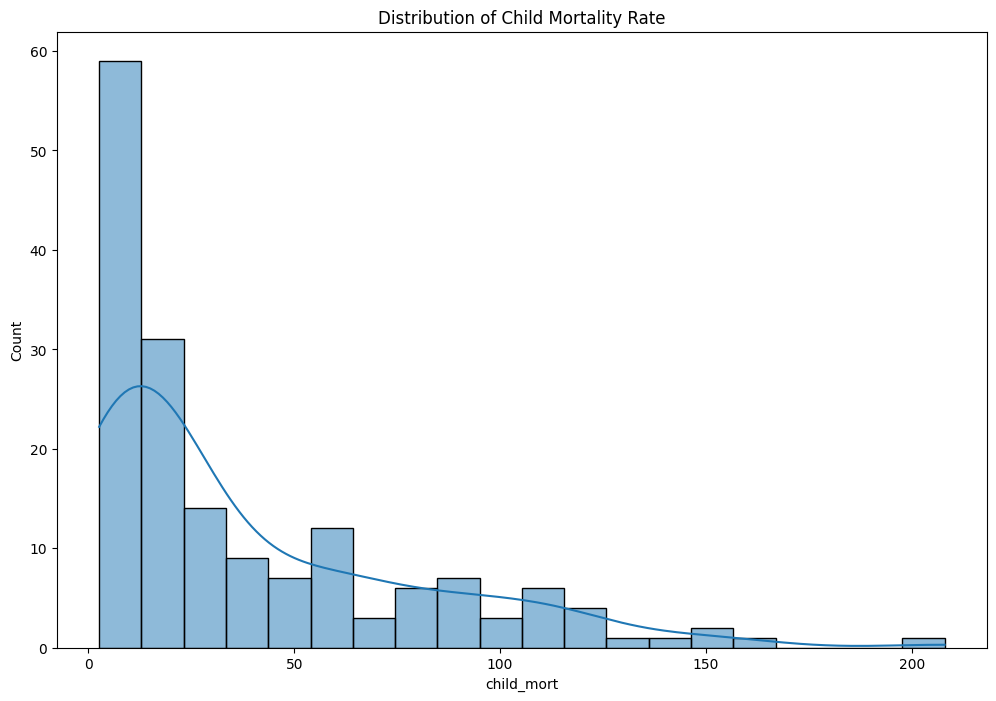

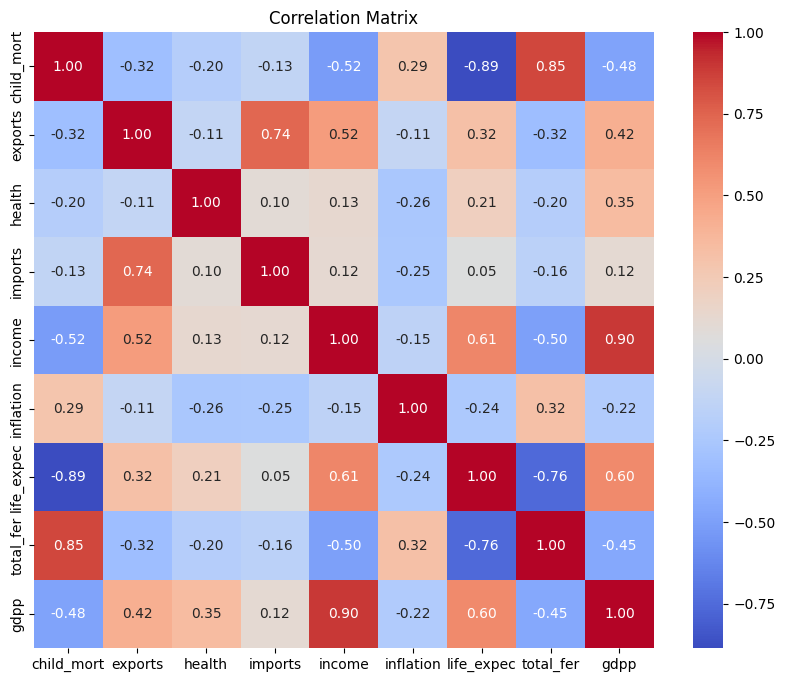

In [7]:
# Візуалізація розподілу числових змінних
plt.figure(figsize=(12, 8))
sns.histplot(data=country_data, x='child_mort', bins=20, kde=True)
plt.title('Distribution of Child Mortality Rate')
plt.show()

# Кореляційна матриця для числових змінних (виключаючи 'country')
numerical_data = country_data.drop('country', axis=1)
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

<Figure size 1500x1000 with 0 Axes>

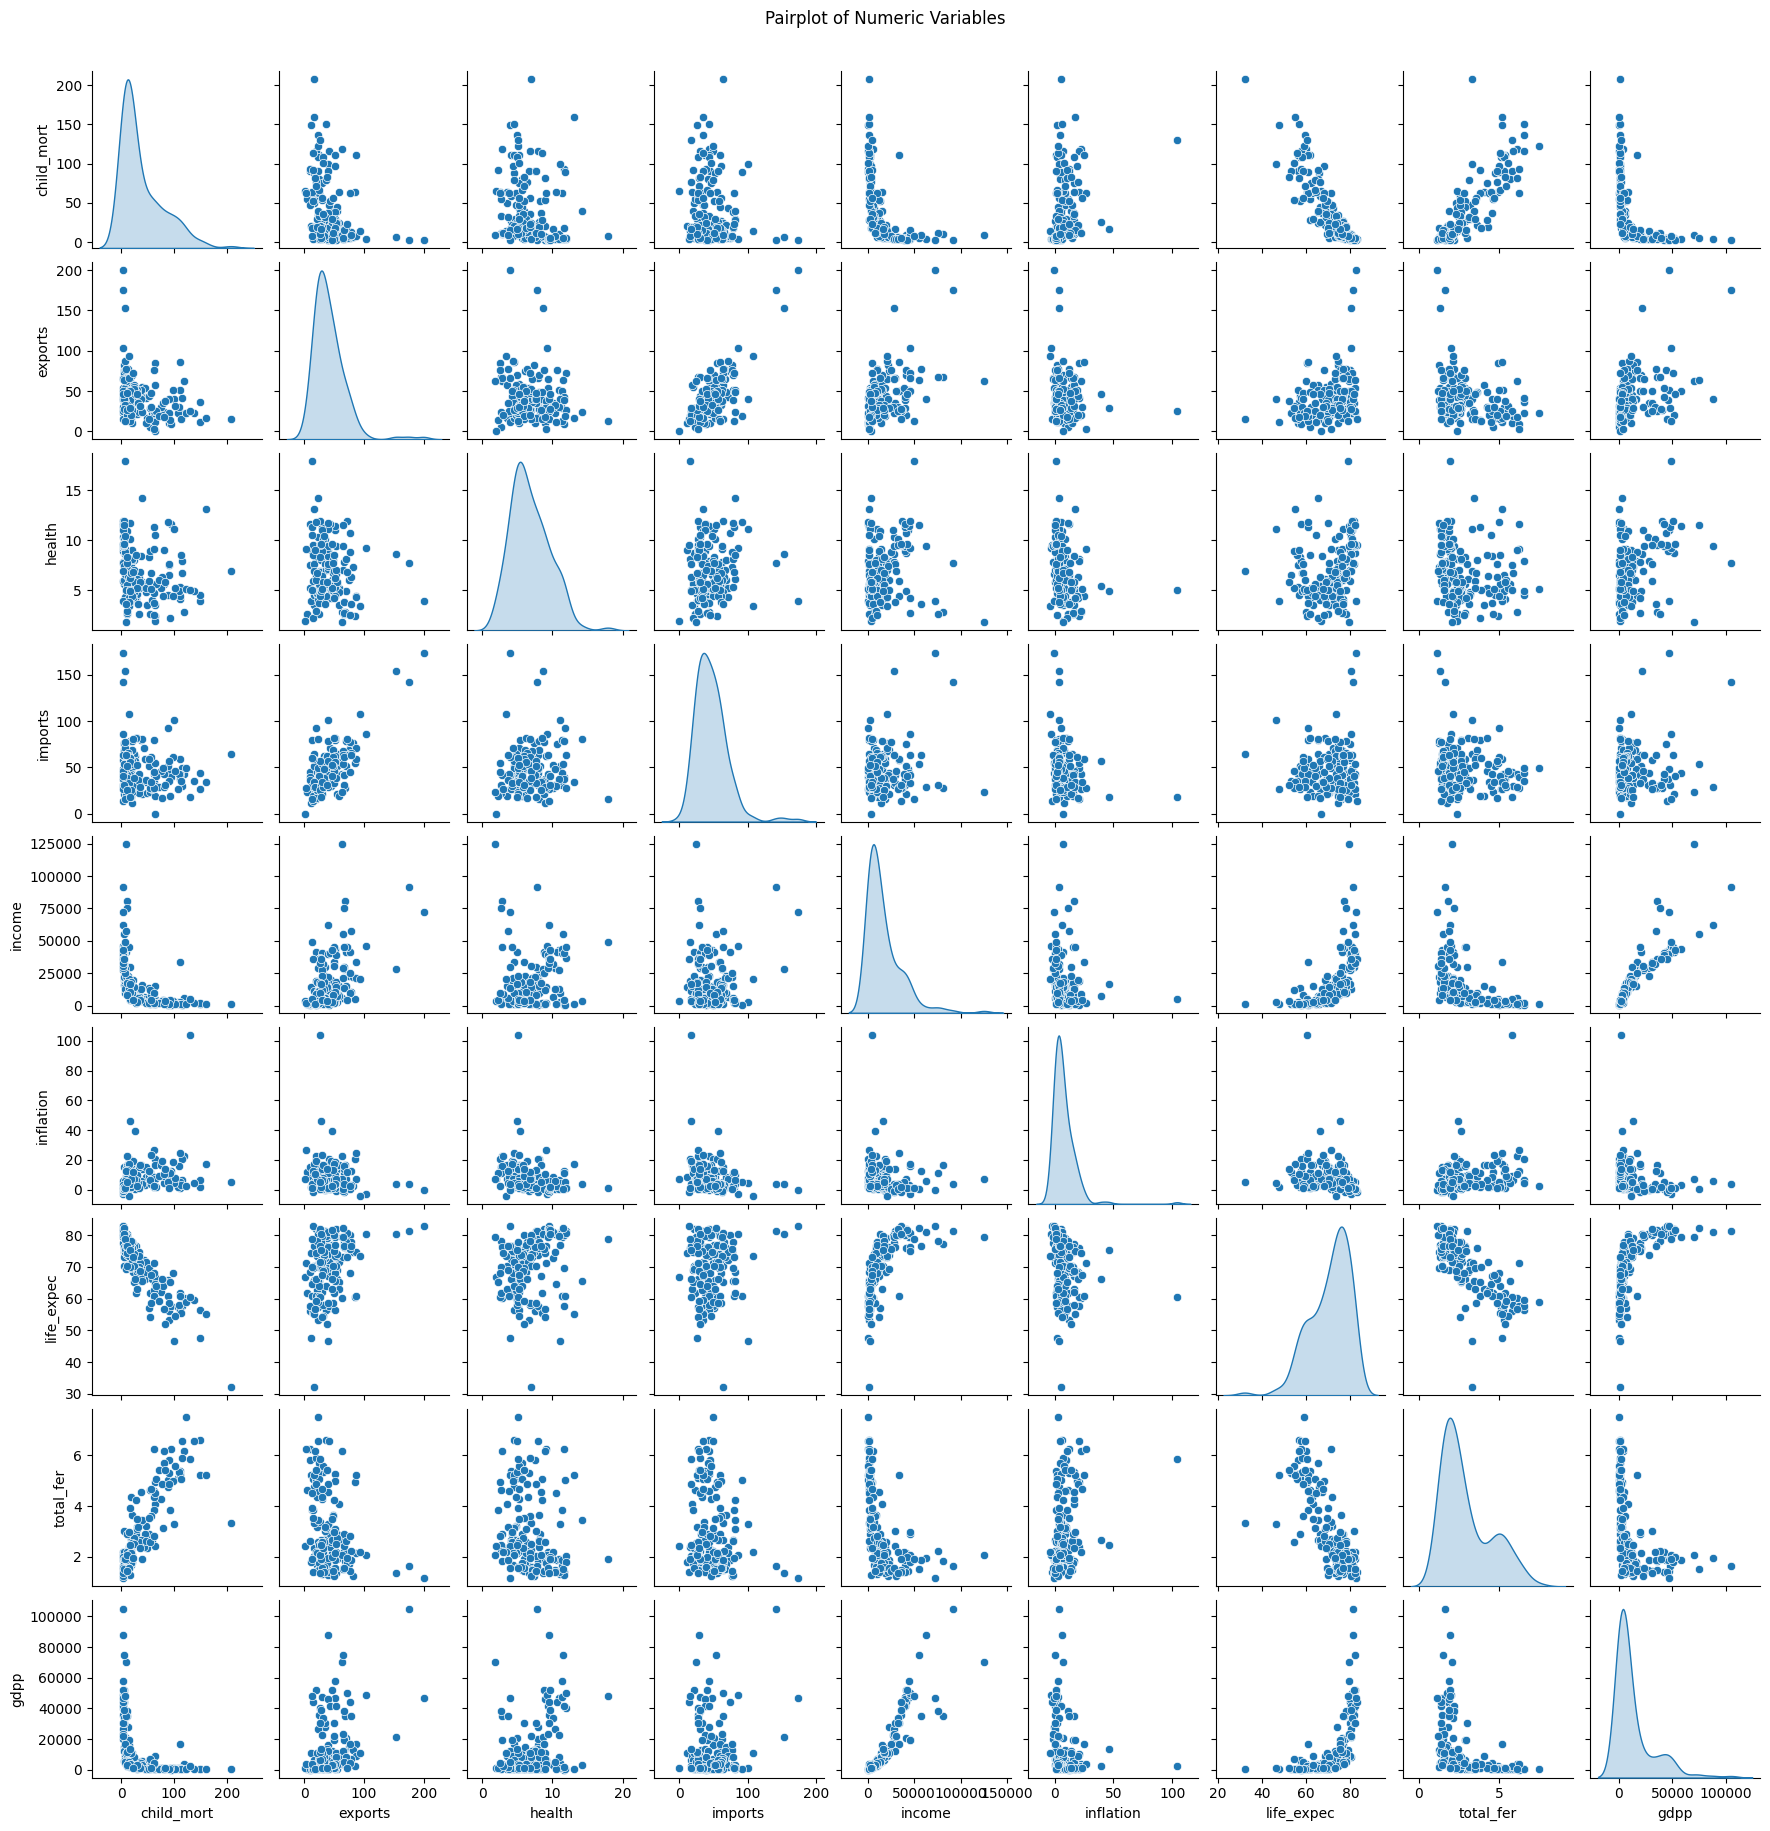

In [41]:
# Візуалізація розподілу усіх числових змінних
plt.figure(figsize=(15, 10))
sns.pairplot(country_data, diag_kind='kde', height=2)
plt.suptitle('Pairplot of Numeric Variables', y=1.02)
plt.show()

In [11]:
# Визначення межі викидів для income
Q1 = country_data['income'].quantile(0.25)
Q3 = country_data['income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Виведення кількості викидів
outliers = country_data[(country_data['income'] < lower_bound) | (country_data['income'] > upper_bound)]
print(f'Number of outliers in income: {len(outliers)}')

# Виведення самі викидів
print(outliers)

Number of outliers in income: 8
                  country  child_mort  exports  health  imports  income  \
23                 Brunei        10.5     67.4    2.84     28.0   80600   
82                 Kuwait        10.8     66.7    2.63     30.4   75200   
91             Luxembourg         2.8    175.0    7.77    142.0   91700   
114                Norway         3.2     39.7    9.48     28.5   62300   
123                 Qatar         9.0     62.3    1.81     23.8  125000   
133             Singapore         2.8    200.0    3.96    174.0   72100   
145           Switzerland         4.5     64.0   11.50     53.3   55500   
157  United Arab Emirates         8.6     77.7    3.66     63.6   57600   

     inflation  life_expec  total_fer    gdpp  
23      16.700        77.1       1.84   35300  
82      11.200        78.2       2.21   38500  
91       3.620        81.3       1.63  105000  
114      5.950        81.0       1.95   87800  
123      6.980        79.5       2.07   70300  
133 

Оскільки країни аутлайнери можна вважати успішними, які не потребують допомоги, то їх можна видалити з нашого датафрейму.

In [17]:
# Вилучення викидів з набору даних
country_data_no_outliers = country_data[(country_data['income'] >= lower_bound) & (country_data['income'] <= upper_bound)].copy()

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(country_data_no_outliers.drop('country', axis=1))

In [24]:
# K-means кластеризація
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
country_data_no_outliers['cluster'] = kmeans.fit_predict(scaled_data)


In [26]:
# Оптимізація числа кластерів за допомогою kneed
ssd = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    ssd.append(kmeans.inertia_)

kl = KneeLocator(range(1, 11), ssd, curve="convex", direction="decreasing")
optimal_k = kl.elbow

In [29]:
# Повторна кластеризація з оптимальним числом кластерів
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
country_data_no_outliers['cluster'] = kmeans.fit_predict(scaled_data)

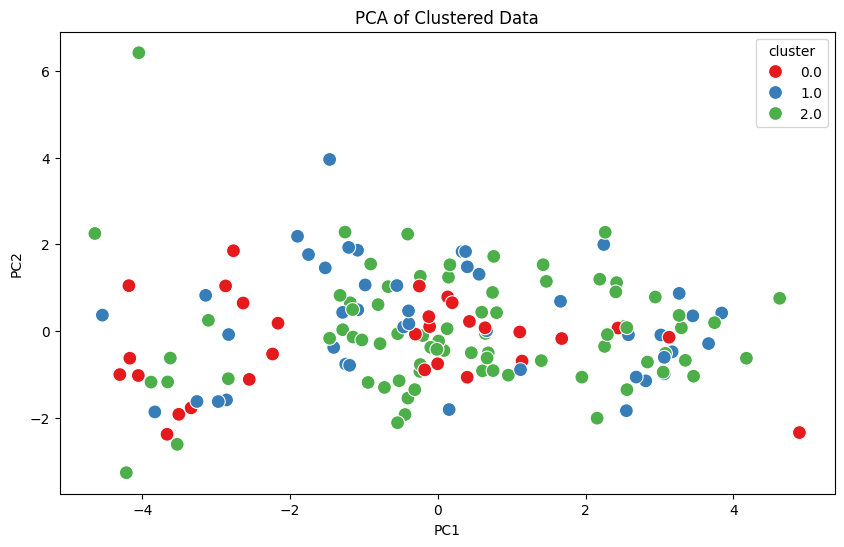

In [31]:
# Візуалізація результатів кластеризації
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['cluster'] = country_data_no_outliers['cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=reduced_df, palette='Set1', s=100)
plt.title('PCA of Clustered Data')
plt.show()

In [38]:
summary = country_data_no_outliers.drop('country', axis=1).groupby('cluster').mean().sort_values(by=['gdpp', 'child_mort', 'income'], ascending=[True, False, True])
print(summary.head())

         child_mort    exports    health    imports        income  inflation  \
cluster                                                                        
1         94.439130  27.983022  6.206957  41.388389   3543.760870  11.879239   
2         22.264634  40.403415  6.349634  48.234146  11492.073171   7.616451   
0          5.451613  48.777419  9.302581  46.064516  36703.225806   2.301645   

         life_expec  total_fer          gdpp  
cluster                                       
1         59.223913   5.007609   1749.782609  
2         72.547561   2.330976   5952.731707  
0         79.712903   1.825161  35590.322581  


In [39]:
# Вибір п'яти країн, які найбільше потребують допомоги
most_needy_countries = country_data_no_outliers[country_data_no_outliers['cluster'] == summary.index[0]].sort_values(by=['gdpp', 'child_mort', 'income'], ascending=[True, False, True]).head(5)
print(most_needy_countries[['country', 'gdpp', 'child_mort', 'income']])

              country  gdpp  child_mort  income
26            Burundi   231        93.6     764
88            Liberia   327        89.3     700
37   Congo, Dem. Rep.   334       116.0     609
112             Niger   348       123.0     814
132      Sierra Leone   399       160.0    1220


Список країн які потребують допомоги:Burundi, Liberia, Congo, Dem. Rep., Niger та Sierra Leone. Вони мають високий рівень смертності дітей, низький рівень доходів та низькі показники ВВП на душу населення.